In [4]:
from smartqa.proc_data.raw_text_proc import RawTextProcessor

with open("data/“严肃”的游戏.txt", "r") as f:
    text = f.read()
rp = RawTextProcessor()
lines = rp.proc_raw_text(text)
lines = rp.merge_paragraph_title(lines)


In [2]:
from smartqa.embedding import embedding_paragraph_bert
import numpy as np
import random
from tqdm import tqdm 

size = len(lines)
n = size
d = 768

# 生成随机向量
vectors = np.zeros((n, d))
for i in range(n):
    for j in range(d):
        vectors[i][j] = random.uniform(-1, 1)

for k in tqdm(range(size)):
    t = embedding_paragraph_bert(lines[k])
    t = t.detach().numpy()
    for j in range(d):
        vectors[k][j] = t[j]

print(vectors.shape)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 67/67 [00:08<00:00,  7.99it/s]

(67, 768)


In [3]:
from transformers import BertTokenizer, BertForNextSentencePrediction
from functools import lru_cache

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')

@lru_cache(500)
def nsm_score(sentence1, sentence2) -> float:

    # 使用tokenizer将句子转换为模型输入
    encoded = tokenizer.encode_plus(sentence1, sentence2, return_tensors='pt', max_length=512, truncation=True, padding='max_length')

    # 调用BERT模型进行下一句预测
    outputs = model(encoded['input_ids'], attention_mask=encoded['attention_mask'])

    # 获取预测结果，输出预测结果
    predictions = outputs.logits
    softmax_predictions = predictions.softmax(dim=-1)
    return softmax_predictions[:, 0].item()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
import random
import numpy as np
from annoy import AnnoyIndex


# 建立索引
t = AnnoyIndex(d, metric='manhattan')
# t.on_disk_build('on_disk.ann')
for i in range(n):
    t.add_item(i, vectors[i])
t.build(10)

# 搜索最接近向量
query = np.zeros(d)
for j in range(d):
    query[j] = random.uniform(-1, 1)

in_txt = "中国传统六艺的游戏形式有哪些"
query = embedding_paragraph_bert(in_txt)
query = query.detach().numpy()

nearest_neighbors = t.get_nns_by_vector(query, 10)

print('Input:', in_txt)
print('最接近向量的索引：', nearest_neighbors)
# nearest_neighbors = sorted(
#     nearest_neighbors,
#     key=lambda x:-nsm_score(in_txt, lines[x])
# )
for idx in nearest_neighbors:
    print(idx, lines[idx])
    # print("score", nsm_score(in_txt, lines[idx]))

Input: 中国传统六艺的游戏形式有哪些
最接近向量的索引： [1, 16, 4, 21, 28, 31, 17, 47, 22, 15]
1 本文为【Paidia系列】的第一篇。Paidia是古希腊语中游戏的意思，通过这个系列，我们想和你更严肃的聊聊游戏。
16 而这种游戏与神圣要素的紧密联系，绝不仅是在希腊才有。
4 游戏和严肃，本来就是十分复杂却又相伴而行的。
21 与其相对，中国传统六艺中的射礼投壶之“游于艺”，本身也是一种游戏形式。
28 正如老勃鲁盖尔（Pieter Bruegel the Elder）所绘制的画作《儿童游戏》（Children's Games），虽然名为儿童游戏，但是我们可以在画中找到许多成年人甚至年纪较大的人的身影。
31 这种游戏中所带的神圣意味在现代逐渐消失了，或者用赫伊津哈的话说，游戏精神失落了。
17 中世纪欧洲基督教伦理中对于“运气游戏”是禁止的，认为其是在妄称神灵的名字，而这种投骰子的运气游戏，也与最早时候的占卜有紧密的关系。
47 在这个意义上，游戏（Padia），连同在哲学家书写中那些“游戏”的同名物的传统被有意识或无意识地遗忘了。
22 或许就如今天我们重新提游戏化学习与游戏教育一样，16-17世纪随着人文主义学者兴起，儿童游戏在当时被看做是一个教育的核心话题。
15 而柏拉图也有明确地表示，“老年人玩游戏和祈祷的时候，应该立刻祈请狄奥尼索斯降临，因为那是狄奥尼索斯给人类消除上了年纪的急躁情绪的礼物。”


In [1]:
lines = [
'我们应该更严肃且更深刻地看待电子游戏的发展和无限潜能，当我们逾越这个光怪陆离、心不在焉的时代，当我们严肃且自觉地推动游戏的媒介发展与成熟，借助美好事物进行娱乐，这时，游戏才会重见天日 。',
 '本文为【Paidia系列】的第一篇。Paidia是古希腊语中游戏的意思，通过这个系列，我们想和你更严肃的聊聊游戏。',
 '日常生活中我们使用游戏这个词时，常常指一种无所谓的玩乐，也常常与“不重要的”，“没有意义的”，“无用的”标签联系在一起。而国外有一类被称作“严肃游戏”（serious game）的游戏，某种意义上从反面印证了这种现状——游戏是“不严肃”的，所以“严肃游戏”似乎是“不同于一般游戏的游戏”。',
 '但实际上，游戏在日常生活中的地位，“游戏”这个词的使用，在历史上并不是像今天那样处于一种容易与“不重要和无意义的”，“无用甚至有害的”话语联系在一起的。',
 '游戏和严肃，本来就是十分复杂却又相伴而行的。',
 '周作人在其1925年出版的翻译小集《陀螺》序中，将其所做的文字工作全都称作“游戏”，并与日常谈论的游戏区分开来，“平常说起游戏，总含有多少不诚实的风雅和故意的玩笑的意味，这也是我所不喜欢的，我的乃是古典文字本义的游戏，是儿戏（Paidia），是玩，书册图象都是（Paignia）之一。”',
 '妄图去定义游戏是困难的，写下《游戏的人：文化的游戏要素研究》的荷兰历史学家约翰赫伊津哈在其1933年的莱顿演讲中所警告的那样：“游戏是一个吞噬一切的范畴，就像愚行（当愚行占据了伊拉斯谟的思想之后）已成了整个世界的女皇时一样”。',
 '但正如贡布里希所评述的，游戏的定义模糊以及游戏与严肃的游离不定的并不意味着我们不能谈论它们，只要我们不要把使用的词看得比历史分期的例子中更重。',
 '让我们尝试“谱系学式”地回到游戏的根源（Herkunft）处，也就是一种尚未区分神圣领域与世俗领域的史前史（Urgeschichte）阶段时，我们可以清晰的看到游戏与神圣的紧密关联。',
 '狄俄尼索斯酒神形象的出现，就带着某种迷狂而神圣的两重性；而就如麦克卢汉所指出的，源起于希腊的奥林匹克运动会原先就是扮演太阳神争斗的游戏——竞技者绕圆形跑道奔跑时，头上扎着黄带，模仿太阳神驾车一日一周所经过的圆形黄道带。',
 '如赫拉克利特所言“哈德斯与狄奥尼索斯，在酒神节为之狂热的颂扬，都是一回事（残篇15）”，死亡的严肃与游戏的欢愉并举，《伊利亚特》中阿克琉斯在朋友尸体前呼唤着他的灵魂，悲痛之情突然就被赛车、拳击、摔跤和剑术比赛爆发出来的欢愉与热情替代了。',
 '在古希腊，柏拉图把游戏等同于神圣，称神圣为游戏，这并未亵渎神圣，反而把游戏概念升华到最高的精神境界。',
 '柏拉图将整个“城邦生活是一场由神所主宰的游戏”，以及“游戏与教育是我们这样的生灵最严肃的工作，因此，我们应该在和平中度过一生中的大部分时间，而且要过得幸福。',
 '正确方法是什么？我们要在玩游戏中度过我们的一生——我指的是某些游戏，亦即献祭、唱歌、跳舞——由此获得上苍的恩宠。”',
 '在赫拉克利特时代，人们的神灵信仰不再虔诚，所谓酒神节蜕变成一种娱乐活动，所以他指责“倘若他们不是以狄奥尼索斯之名举行赛会和阳具崇拜的活动，那就是极为可耻的。（残篇15）”',
 '而柏拉图也有明确地表示，“老年人玩游戏和祈祷的时候，应该立刻祈请狄奥尼索斯降临，因为那是狄奥尼索斯给人类消除上了年纪的急躁情绪的礼物。”',
 '而这种游戏与神圣要素的紧密联系，绝不仅是在希腊才有。',
 '中世纪欧洲基督教伦理中对于“运气游戏”是禁止的，认为其是在妄称神灵的名字，而这种投骰子的运气游戏，也与最早时候的占卜有紧密的关系。',
 '而中国传统文化中驱傩活动，赶鬼之时必然伴随着欢笑，好年景靠的是节令庆典中正规迎神赛社——“风乎舞雩，咏而归”。',
 '而在描述原始仪式过程中，时刻都可见到游戏的影子，以至于赫伊津哈梳理了人类学的研究后，把仪式行为，或仪式行为中的重要部分都看作游戏范畴之内，认为原始仪式就是神圣的游戏，野蛮人世界就是儿童、诗人的游戏世界。',
 '游戏在古希腊首先被当做教育的方式，“请不要强迫孩子们学习，要用做游戏的方法，你可以在游戏中更好地了解到他们每个人的天性。”。作为总体人文学“拜德雅”(paideia)，其与“游戏”(paidia)的词源关联再明显不过。',
 '与其相对，中国传统六艺中的射礼投壶之“游于艺”，本身也是一种游戏形式。',
 '或许就如今天我们重新提游戏化学习与游戏教育一样，16-17世纪随着人文主义学者兴起，儿童游戏在当时被看做是一个教育的核心话题。',
 '蒙田认为“儿童游戏其实不是游戏，应该看作是他们最严肃的举动”，伊拉斯谟认为应该让游戏来促进孩子的学习兴趣（但对于游戏中的克制与行为举止有要求），而拉伯雷《巨人传》中，游戏更是直接成了新式教育的工具。',
 '教育与儿童游戏也是共同体稳定的源泉，“提到儿童的游戏，我认为我们的共同体对此陷入了一种普遍的无知状态，看不到它对我们已经制定的法律能否永久保存起着决定性的影响。”',
 '所以对于希腊人来说，游戏应该是神圣的，故有“城邦生活是一场由神所主宰的游戏”，而值得提及的是“游戏与教育是我们这样的生灵最严肃的工作，因此，我们应该在和平中度过一生中的大部分时间，而且要过得幸福。',
 '正确方法是什么？我们要在玩游戏中度过我们的一生——我指的是某些游戏，亦即献祭、唱歌、跳舞——由此获得上苍的恩宠。”',
 '这样的游戏所型塑的共同体生活的形态在法国中世纪的“游戏共同体”也可见一斑。',
 "正如老勃鲁盖尔（Pieter Bruegel the Elder）所绘制的画作《儿童游戏》（Children's Games），虽然名为儿童游戏，但是我们可以在画中找到许多成年人甚至年纪较大的人的身影。",
 '在中世纪，包括教士和贵族这些特权阶层在内，所有人共享同样的生活方式。游戏是在一个这样充满着危险的世界里谋求生存的体系和纽带，游戏社团在驱逐恐惧寻求神灵保护以及作为社群自治中扮演重要的角色。',
 '无独有偶，人类学家格尔茨在《文化的阐释》中记录了巴厘岛的斗鸡的“深度游戏”的民族志中，巴厘岛原住民对于他的接纳，正是在他参与了斗鸡游戏后才发生的，这就像当有人学会了希腊传统游戏后，希腊人对他说“你现在是个希腊人了”。',
 '这种游戏中所带的神圣意味在现代逐渐消失了，或者用赫伊津哈的话说，游戏精神失落了。',
 '奥运会（Olympics Games）已经成为了四年一度，事关民族国家的荣誉与软实力的严肃之物，而这样冠着游戏的名字的严肃盛会，其严肃性以及“游戏”这一个词所蕴藏的无意义与玩笑的意味存在剧烈的冲突。',
 '原因在于在“随着体育运动日益系统化、组织化，某种纯粹地游戏特征不可避免的丢失了”，它缺乏自主，不能随心所欲。',
 '现代奥运会之父顾拜旦，所提出的三条原则“非职业化/非政治化/非商业化”已经一条不剩地被民族主义和资本主义所大肆掩盖与僭越。',
 '体育竞技活动（Games）的职业化赫伊津哈在《游戏的人》的结尾将其描述为一种游戏精神的失落，体育运动被推离真正的游戏领域，越来越远，直到它自成一体（sui generis）：既非游戏，也不当真。',
 '“这项活动名义上叫做游戏，却被提升到专业化组织和科学化精确的高度，致使真正的游戏精神面临消亡的威胁”。',
 '而伴随着电竞以及网络的普及，人们开始汲汲于排位赛的上分。当人们看着在各种视频平台他人的神仙操作而构造出“需要有怎样的操作才能算是会玩游戏”，而不是从自己的进步和乐趣中获得满足感的时候的，那种闲适的，非必要的游戏本质也就丢失了。',
 '首当其冲的，早在十八世纪，功利主义、追求枯燥无味的效率和资产阶级的社会福利观念就已经深深地侵蚀社会。',
 '劳动与游戏（Spiel）本互相排斥，而如今，游戏却要服从于生产。显而易见的是以游戏（Game）为名博弈论（Game Theory）的经济学算计的理论，用数学模型来计算在理性人决策之间的研究，完全依照一种纯功利性的方式开展研究，令人惊讶的是，这样对于游戏（Game）一词的使用，完全站在了游戏精神的反面。',
 '新教伦理精神所蕴藏的财富无限积累，以及对于非生产性活动排斥的禁欲主义一下子把曾经在亚里士多德哲学中拥有重要地位的休闲的目的论给颠倒过来（工作生产的目的不再是为了休闲与安逸，反倒是人们休闲，为了更高效率地工作）。',
 '而资本主义计量的时间观，人们开始重视每分每秒时间的流逝，“时间就是生命，效率就是金钱”，这种精打细算与节庆，以及作为游戏的艺术自身“属己的”时间性有巨大的矛盾，人们不再能容许花费大量时间在这种无用的事物上。',
 '“游戏”在《判断力批判》中是重要概念，而康德也确实在文章中提及了具体现实的游戏以及休闲的看法，包括其对于“运气游戏”，“音调游戏”，“思想游戏”以及它们和健康之间的关系。',
 '而席勒则将游戏发展为《审美教育书简》中最为重要的概念，席勒甚至认为“人只有在游戏的时候，才是完整的人。”这与麦克卢汉所说的““没有艺术的人，没有游戏这种大众艺术的人，往往像毫无意识的自动机器。”异曲同工。',
 '美学理论和审美自主性（aesthetic autonomy）的发展，作为语言的“游戏”与现实中游戏的距离进一步拉远。一种不严肃的游戏反而成为了法兰克福学派批评的对象，学者们甚至直接完全否认康德美学中游戏的现实来源，这种对游戏谱系的不了解而泛泛而谈的态度依旧长存留于今。',
 '如同阿利埃斯(Phillippe Ariès)所认为的，“游戏史是游戏由庄重变为浅薄的历史”。',
 '康德，席勒，之后在其上重新回到前文所提及的古希腊悲剧酒神游戏的尼采，海德格尔，伽达默尔美学和艺术哲学的序列，还有麦克卢汉，他们所谈论的游戏一词，在现实中早已失去了它的对应物——而更别提蕴藏在其中原本的神圣与创造之维度，只能沦为一个抽象的比喻或者概念加以理解。',
 '在这个意义上，游戏（Padia），连同在哲学家书写中那些“游戏”的同名物的传统被有意识或无意识地遗忘了。',
 '这是一个电子游戏借助技术重新以“游戏”之名发展成熟并且造成有广泛影响力的时代，在小部分的一些优秀的电子游戏中能瞥见艺术的时代精神的闪现。',
 '这个时代大部分的电子游戏或许仅可被称作娱乐（Unterhaltung），而无法称作真正的游戏（Spiel）。',
 '“没有游戏要素，就不可能有真正的文明。”赫伊津哈结尾做出了这样的论断。“把游戏的纯粹的亵渎召命归还游戏”，阿甘本如是说。',
 '我们应该更严肃且更深刻地去看待电子游戏的发展与无限潜能，当我们逾越这个光怪陆离、心不在焉的时代，当我们严肃且自觉地推动游戏的媒介发展与成熟，“借助美好事物进行娱乐，这时‘游戏’（Spiel）才会重见天日”。',
 '1.周作人译，肖毛校：《陀螺》，新潮社文艺丛书之七，1925年6月。',
 '3.贡布⾥希：《游戏的⾼度严肃性：约翰·赫伊津哈<游戏的⼈>随感》转引⾃赫伊津哈：《游戏的⼈》多⼈译，杭州：中国美术学院出版社，1996，第291页。',
 '4.吉奥乔·阿甘本《万物的签名：论方法》北京：中央编译出版社，2017年，第104-112页。',
 '6.奥乔·阿甘本《幼年与历史：经验的毁灭》北京：河南大学出版社，2016年，第118页。',
 '7.伊津哈：《游戏的人》，傅存良译，北京大学出版社，第21、286页及302页。',
 '8.柏拉图 ：《柏拉图全集第3卷》，王晓朝译，人民出版社，2003年，第561页。',
 '9.付立峰：《“游戏”的哲学：从赫拉克利特到德里达》，中国社会科学出版社，2012年，第7页。',
 '10.柏拉图：《法律篇》，张志仁、何勤华译上海人民出版社，2001年，第56页。',
 '11.唐运冠：法国中世纪至近代早期的游戏伦理，《世界历史》2019年第1期。',
 '12.杨庆堃：《中国社会中的宗教》范丽珠等译，上海人民出版社，2007年，第89页。',
 '14.唐运冠：《游戏与法国 11-17世纪的社会演变》 浙江大学，博士论文，2013年，第146页。',
 '15.柏拉图\xa0：《柏拉图全集第3卷》，王晓朝译，人民出版社，2003年，第553页。',
 '18.韩炳哲，关玉红译：《娱乐何为》北京：中信出版集团，2019年，第1页及第96-110页。',
 '20.康德：《康德美学文集》，曹俊峰译，北京师范大学，2003年，第193、217页。',
 '22.吉奥乔·阿甘本：《渎神》王立秋译，北京大学出版社，2017年，第124-160页。'
]

In [40]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [50]:
# 以下代码参考 https://github.com/openai/openai-cookbook/blob/main/apps/web-crawl-q-and-a/web-qa.ipynb
import pandas as pd
import os
from smartqa.proc_data.raw_text_proc import RawTextProcessor

# Create a list to store the text files
texts=[]

rtp = RawTextProcessor()
cnt = 0
# Get all the text files in the text directory
for file in os.listdir("data/"):
    cnt += 1

    # Open the file and read the text
    with open("data/" + file, "r") as f:
        # text = f.read()
        # Omit the first 7 lines and then replace -, _,  with spaces.
        lines = rtp.proc_raw_text(text)
        lines = rtp.merge_paragraph_title(lines)
        for line in lines:
            print(line)
            texts.append((file.replace('.txt', ''), line))
    if cnt >= 3:
        break

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

title: Stefano Gualeni 什么是一个哲学游戏 What is a Philosophical Game (2022)
译者注。但我依然觉得阅读和翻译本文让我受益良多，希望对你也有所启发。
Stefano Gualeni。
Stefano Gualeni 什么是一个哲学游戏 What is a Philosophical Game (2022)。
摘要 Abstract。
简介：哲学性虚构 Philosophical Fictions。
哲学主题 Philosophical Themes。
哲学游戏 Philosophical Games。，哲学游戏是一种互动的虚拟世界，旨在让玩家在游戏中（或围绕其）进行哲学思考。
1.交互性（Interactivity）：在游戏虚构世界中的在场与归属感主要是通过玩家与游戏中的物体、人物和事件进行持续而清晰交互的可能性所支撑。游戏世界的可操作性（manipulability）和响应性（responsiveness）使玩家得以在这些世界中做出有意义的决定和行动。玩家的决策和行动是否具有哲学相关性，取决于它们所处的上下文，和游戏设计师为它们规划的结果。总的来说，很明显，游戏和数字游戏的交互性所提供的哲学潜能依赖于玩家对自己的行为负责，并接受游戏的邀请对这些行为进行批判性反思。
2.可重玩性（Replayability）: 游戏中的情境可以通过多种方式进行互动。在大多数游戏中，玩家有可能反复尝试这些情境，直到他们对事态的结果感到满意（或直到探索了所有可能的选项）。这可能发生在多次游戏过程中，或者当游戏恢复到先前的保存状态时。作为游戏玩法的体验的一部分，重玩性的特征允许玩家以一种易变的（fluid）且无需担责的（non-committal）方式处理游戏中的场景与挑战，而这是在现实世界采取这些行动和决定时通常不会有的选择（Gualeni & Vella 2020, 110 -114）。由于游戏的可重玩性，玩家能够根据对结果的经验性知识来评估（并或许修改）自己的决定和行动。因此，这一特性的哲学潜能在于，它揭示了偶然性（contingency ）内在于任何给定情境中的事实，并有助于使玩家对事件现状及其可能发展的思考方式「流动化」（fluidifying）（ibid）。
3.更高程度的虚构完整性（A higher degree o

/var/folders/fd/4cmmgt254k906g8grfh_nk2m0000gn/T/ipykernel_80701/2931785837.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


,fname,text
0,David Krakauer 与达尔文下围棋 Playing Go with Darwin ...,David Krakauer 与达尔文下围棋 Playing Go with Darwin ...
1,David Krakauer 与达尔文下围棋 Playing Go with Darwin ...,David Krakauer 与达尔文下围棋 Playing Go with Darwin ...
2,David Krakauer 与达尔文下围棋 Playing Go with Darwin ...,David Krakauer 与达尔文下围棋 Playing Go with Darwin ...
3,David Krakauer 与达尔文下围棋 Playing Go with Darwin ...,David Krakauer 与达尔文下围棋 Playing Go with Darwin ...
4,David Krakauer 与达尔文下围棋 Playing Go with Darwin ...,David Krakauer 与达尔文下围棋 Playing Go with Darwin ...


<AxesSubplot: >

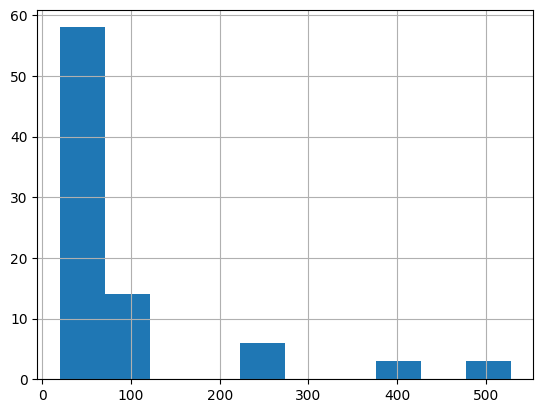

In [51]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [52]:
import re
max_tokens = 512

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('。')
    # sentences = re.split(r'。')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<AxesSubplot: >

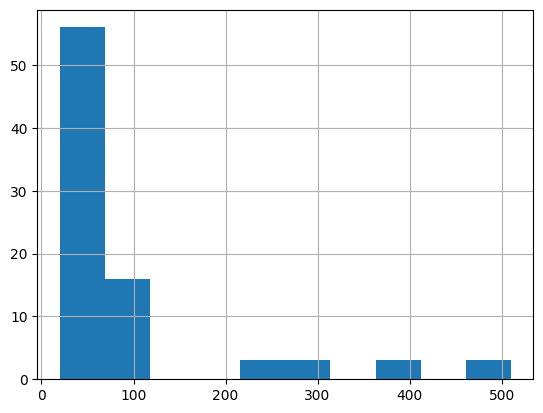

In [53]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [54]:
from smartqa.embedding import embedding_paragraph_bert

df['embeddings'] = df.text.apply(lambda x: str(list(embedding_paragraph_bert(x))))
df.to_csv('processed/embeddings.csv')
df.head()

,text,n_tokens,embeddings
0,David Krakauer 与达尔文下围棋 Playing Go with Darwin ...,50,"[-0.07852434, -0.10041817, 0.2895778, -0.38683..."
1,David Krakauer 与达尔文下围棋 Playing Go with Darwin ...,69,"[0.24560016, 0.2515622, 0.37217325, -0.8038252..."
2,David Krakauer 与达尔文下围棋 Playing Go with Darwin ...,27,"[0.04044876, -0.1748496, 0.2199534, -0.3849564..."
3,David Krakauer 与达尔文下围棋 Playing Go with Darwin ...,49,"[0.047210183, -0.16733712, 0.23779012, -0.3927..."
4,David Krakauer 与达尔文下围棋 Playing Go with Darwin ...,27,"[0.04528706, 0.08628458, 0.011326332, -0.49781..."


In [55]:
# Load embedding from csv file
df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,David Krakauer 与达尔文下围棋 Playing Go with Darwin ...,50,"[-0.07852434, -0.10041817, 0.2895778, -0.38683..."
1,David Krakauer 与达尔文下围棋 Playing Go with Darwin ...,69,"[0.24560016, 0.2515622, 0.37217325, -0.8038252..."
2,David Krakauer 与达尔文下围棋 Playing Go with Darwin ...,27,"[0.04044876, -0.1748496, 0.2199534, -0.3849564..."
3,David Krakauer 与达尔文下围棋 Playing Go with Darwin ...,49,"[0.047210183, -0.16733712, 0.23779012, -0.3927..."
4,David Krakauer 与达尔文下围棋 Playing Go with Darwin ...,27,"[0.04528706, 0.08628458, 0.011326332, -0.49781..."


In [60]:
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

q_embeddings = embedding_paragraph_bert("研究人员最近在《科学》杂志上写道：「自然选择本身能够创造出使达尔文进化论能够成功的条件」他们详细介绍了在大肠杆菌中进行的蛋白质实验。")
# Get the distances from the embeddings
df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')

returns = []
cur_len = 0

# Sort by distance and add the text to the context until the context is too long
for i, row in df.sort_values('distances', ascending=True).iterrows():
    
    # Add the length of the text to the current length
    cur_len += row['n_tokens'] + 4
    
    # If the context is too long, break
    if cur_len > 1500:
        break
    
    # Else add it to the text that is being returned
    returns.append(row["text"])

In [61]:
returns

['诗歌与游戏：数字游戏中的一种文学可能. *目前正逐渐搜集和整理这类特殊的游戏为《变态者游戏清单》，除了赞赏文章外，也欢迎在爱发电',
 '游戏和诗的“无用”对话. 1.交互性（Interactivity）：在游戏虚构世界中的在场与归属感主要是通过玩家与游戏中的物体、人物和事件进行持续而清晰交互的可能性所支撑。游戏世界的可操作性（manipulability）和响应性（responsiveness）使玩家得以在这些世界中做出有意义的决定和行动。玩家的决策和行动是否具有哲学相关性，取决于它们所处的上下文，和游戏设计师为它们规划的结果。总的来说，很明显，游戏和数字游戏的交互性所提供的哲学潜能依赖于玩家对自己的行为负责，并接受游戏的邀请对这些行为进行批判性反思。',
 'David Krakauer 与达尔文下围棋 Playing Go with Darwin (2020). 1.交互性（Interactivity）：在游戏虚构世界中的在场与归属感主要是通过玩家与游戏中的物体、人物和事件进行持续而清晰交互的可能性所支撑。游戏世界的可操作性（manipulability）和响应性（responsiveness）使玩家得以在这些世界中做出有意义的决定和行动。玩家的决策和行动是否具有哲学相关性，取决于它们所处的上下文，和游戏设计师为它们规划的结果。总的来说，很明显，游戏和数字游戏的交互性所提供的哲学潜能依赖于玩家对自己的行为负责，并接受游戏的邀请对这些行为进行批判性反思。',
 '游戏和诗的“无用”对话. *目前正逐渐搜集和整理这类特殊的游戏为《变态者游戏清单》，除了赞赏文章外，也欢迎在爱发电',
 '诗歌与游戏：数字游戏中的一种文学可能. 译者注。但我依然觉得阅读和翻译本文让我受益良多，希望对你也有所启发。',
 '诗歌与游戏：数字游戏中的一种文学可能. 1.交互性（Interactivity）：在游戏虚构世界中的在场与归属感主要是通过玩家与游戏中的物体、人物和事件进行持续而清晰交互的可能性所支撑。游戏世界的可操作性（manipulability）和响应性（responsiveness）使玩家得以在这些世界中做出有意义的决定和行动。玩家的决策和行动是否具有哲学相关性，取决于它们所处的上下文，和游戏设计师为它们规划的结果。总的来说，很明显，游戏和数字游戏的交互性所提供的哲学潜